# COVID-19 Discussion in Albertan Subreddits

Reddit is a popular forum for the discussion of local issues. Every day, Albertans submit hundreds of submissions and thousands of comments across the [`/r/alberta`](https://www.reddit.com/r/alberta/), [`/r/edmonton`](https://www.reddit.com/r/Edmonton/), and [`/r/calgary`](https://www.reddit.com/r/Calgary/) subreddits. Comments from these subreddits offer a unique look into the thoughts of Albertans as we navigate the COVID-19 pandemic. 

In this notebook we will use data from comments made in the three major Albertan subreddits to track the emergence of the COVID-19 pandemic as a major factor in the lives of Albertans. To determine if comments are relevant to a set of topics related to the pandemic, we will use an unsupervised text classification model. For more in-depth implementation details see the [accompanying code in this repo](https://github.com/epsalt/reddit-c19-analysis).

The final result is the figure below, which shows the frequency of comments related to topics relevant to the pandemic:

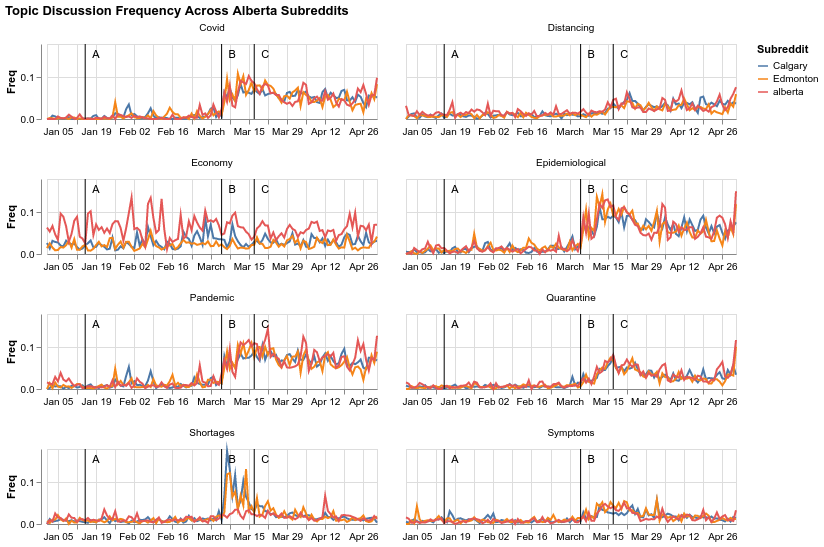

In [1]:
import json
import altair as alt
## alt.renderers.enable('mimetype')

with open("assets/chart.json") as f:
    spec = json.load(f)
    
alt.Chart.from_dict(spec)

| Label | Date      | Event                                   |
|:-----:|:---------:|:----------------------------------------|
| A     |2020-01-15 | Canada's first case                     |
| B     |2020-03-05 | Alberta's first case                    |
| C     |2020-03-17 | Canada Declares Public Health Emergency |

## The Pushshift Reddit Dataset

Data for this project was compiled using the [Pushshift](https://pushshift.io/) API. Pushshift is a social media data collection platform that has archived Reddit data since 2015. For more information, see [*The Pushshift Reddit Dataset*](https://arxiv.org/abs/2001.08435). For the Python code used to request data from the Pushshift API, see [pushshift.py](https://github.com/epsalt/reddit-c19-analysis/blob/master/pushshift.py). 

Data compiled for this project included 22682 submissions and 487072 comments from the `/r/alberta`, `/r/calgary`, and `/r/edmonton` subreddits between January 1, 2020 and May 1, 2020. Only comment data was used for this project but future work could incorporate submissions into the analysis. 

|Subreddit  | Submissions | Comments   | 
|-----------|-------------|------------|
| Alberta   |  4934       | 123827     |
| Calgary   |  10279      | 229931     |
| Edmonton  |  7469       | 133314     |
| **Total** |  **22682**  | **487072** |

The compiled data in compressed `jsonl` format can be downloaded here:
- Comments (68MB): https://alberta-reddit-data.s3-us-west-2.amazonaws.com/coms.jsonl.gz
- Submissions (9MB): https://alberta-reddit-data.s3-us-west-2.amazonaws.com/subs.jsonl.gz

## Running this notebook

This Jupyter notebook can be run on your own machine by following these steps:

```bash
# Clone the repo
$ git clone https://github.com/epsalt/reddit-c19-analysis
$ cd reddit-c19-analysis

# Install dependencies
$ pip install -r requirements.txt
$ python -m spacy download en_core_web_sm

# Download comment data
$ curl https://alberta-reddit-data.s3-us-west-2.amazonaws.com/coms.jsonl.gz -o coms.jsonl.gz
$ gunzip -d coms.jsonl.gz -c > data/coms.jsonl

# Or use `pushshift.py` to request data from the pushshift API 
# - Requests are rate limited, so this can take a while
# - Date ranges or subreddits can be changed in the source
$ python pushshift.py

# Run the notebook
$ jupyter notebook c19-reddit-alberta.ipynb
```

This notebook was run on an Arch Linux machine with an AMD Ryzen 5 2600X CPU 3.60GHz (6 cores) and 16 GB memory. Running the entire notebook takes around 5 minutes.

In [2]:
from IPython.display import Markdown, HTML

## Preprocessing comment text

Before training the model, comment text first needs to be preprocessed. Reddit comments are messy: they can include emojis, misspellings, URLS, and other comments embedded as quotes.

In [3]:
# An example messy comment
# www.reddit.com/r/Edmonton/comments/fo4ne7/when_do_i_start_to_stay_home/fliscp9/

comment = "&gt;They could mean that if you get good rest you won't show symptoms in many cases.\n\nI'm assuming they aren't stupid and therefore aren't actually proposing that getting a good enough sleep will actually cause you to be asymptomatic for any disease, let alone COVID-19.\n\n&gt; Confirmed cases are when people have been tested. \n\nGiven that so many countries are currently only testing people with symptoms and are not even routinely testing asymptomatic front-line workers, I am okay with an assumption that \"confirmed cases\" is fairly equivalent \"confirmed symptomatic cases\".\n\nAlso, this is my source for \"80% of cases are mild\":\n\n[https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200301-sitrep-41-covid-19.pdf?sfvrsn=6768306d\\_2](https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200301-sitrep-41-covid-19.pdf?sfvrsn=6768306d_2)\n\n&gt;  Among 44672 patients in China with confirmed infection, 2.1% were below the age of 201.  The most commonly reported symptoms included fever, dry cough, and shortness of breath,and most patients (80%) experienced mild illness. Approximately14% experienced severe disease and 5% were critically ill.  \n\nNote that \"confirmed infection\" terminology here and that any number of asymptomatic people in this particular sample was &lt; 1%.\n\nSo, claiming that I am making a big assumption here seems unwarranted. I certainly didn't make this up; I am quoting the data from a WHO report on a large sample. Certainly as we learn more have more data and have some replicated studies that perform blanket testing in large populations, we might find that asymptomatic cases are indeed high. I am open to that possibility."
Markdown(comment)

&gt;They could mean that if you get good rest you won't show symptoms in many cases.

I'm assuming they aren't stupid and therefore aren't actually proposing that getting a good enough sleep will actually cause you to be asymptomatic for any disease, let alone COVID-19.

&gt; Confirmed cases are when people have been tested. 

Given that so many countries are currently only testing people with symptoms and are not even routinely testing asymptomatic front-line workers, I am okay with an assumption that "confirmed cases" is fairly equivalent "confirmed symptomatic cases".

Also, this is my source for "80% of cases are mild":

[https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200301-sitrep-41-covid-19.pdf?sfvrsn=6768306d\_2](https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200301-sitrep-41-covid-19.pdf?sfvrsn=6768306d_2)

&gt;  Among 44672 patients in China with confirmed infection, 2.1% were below the age of 201.  The most commonly reported symptoms included fever, dry cough, and shortness of breath,and most patients (80%) experienced mild illness. Approximately14% experienced severe disease and 5% were critically ill.  

Note that "confirmed infection" terminology here and that any number of asymptomatic people in this particular sample was &lt; 1%.

So, claiming that I am making a big assumption here seems unwarranted. I certainly didn't make this up; I am quoting the data from a WHO report on a large sample. Certainly as we learn more have more data and have some replicated studies that perform blanket testing in large populations, we might find that asymptomatic cases are indeed high. I am open to that possibility.

In [4]:
from analysis import regex_replace, tokenize

docs = regex_replace(comment) # Regex substitution to remove comment replies, links, non-ascii chars
tokens = tokenize([docs])[0]  # Tokenization and lemmatization with spacy

tokens

'assume stupid actually propose get good sleep actually cause asymptomatic disease let covid-19 given country currently test people symptom routinely test asymptomatic line worker okay assumption confirm case fairly equivalent confirm symptomatic case source case mild note confirm infection terminology numb asymptomatic people particular sample lt claim make big assumption unwarranted certainly quote datum report large sample certainly learn datum replicate study perform blanket test large population find asymptomatic case high open possibility'

In [5]:
%%time

import dask
from analysis import preprocess

# Preprocess comment text
with dask.config.set(scheduler="processes"):
    df = preprocess("data/coms.jsonl")

sentences = [str(doc).split() for doc in df["tokens"].to_list()]
df.head()

CPU times: user 1min 6s, sys: 567 ms, total: 1min 7s
Wall time: 1min 10s


,created_utc,subreddit,tokens
0,2020-05-01 05:56:35,Calgary,approach household member live work limit soci...
1,2020-05-01 05:55:27,Calgary,proof drive photo radar picture take s demerit...
2,2020-05-01 05:55:24,Calgary,fun book table
5,2020-05-01 05:52:14,Calgary,get photo radar ticket cancel crown
7,2020-05-01 05:50:59,Calgary,haha worth bet deliver tomorrow close


## Word2vec model

After the comment text has been preprocessed, we can use it to train a model. For this project we are using a text classification model called [`word2vec`](https://en.wikipedia.org/wiki/Word2vec) which produces word embeddings, a vector representation of textual data. With a corpus of ~400k preprocessed comments and a vector size of 300 the model took about 2 minutes to train using the [gensim](https://radimrehurek.com/gensim/models/word2vec.html) `word2vec` implementation.

In [6]:
%%time

from model import W2vModel # gensim wrapper

# Train the model
model = W2vModel()
model.train(sentences)
model.save("models")

CPU times: user 10min 37s, sys: 11min 42s, total: 22min 20s
Wall time: 2min 12s


Some checks to make sure word similarities make sense:

In [7]:
# Find words similar to 'covid'

model.ft.wv.similar_by_word("covid")

[('covid19', 0.7980427145957947),
 ('covid-19', 0.7620994448661804),
 ('coronavirus', 0.646454930305481),
 ('virus', 0.6149610877037048),
 ('symptomatic', 0.5933961868286133),
 ('asymptomatic', 0.5785079598426819),
 ('pneumonia', 0.5708344578742981),
 ('illness', 0.5698176622390747),
 ('hospitalize', 0.5587728023529053),
 ('pandemic', 0.5553447008132935)]

In [8]:
# Find words similar to 'mask'

model.ft.wv.similar_by_word("mask")

[('n95', 0.7694867849349976),
 ('masks', 0.7566391229629517),
 ('ppe', 0.7450969219207764),
 ('respirator', 0.7188060283660889),
 ('n95s', 0.6961692571640015),
 ('surgical', 0.6508617997169495),
 ('facemask', 0.6502605080604553),
 ('glove', 0.6302595138549805),
 ('p100', 0.6072518825531006),
 ('wearing', 0.5903509855270386)]

In [9]:
# Check similarity of some word pairings
# More similar = higher score

pairs = [("covid-19", "coronavirus"), # related
         ("dog", "pandemic"),         # not related
         ("cat", "dog"),              # related
         ("house", "turkey"),         # not related
         ("trudeau", "notley")]       # related

for pair in pairs:
    similarity = model.ft.wv.similarity(*pair)
    print(f"{', '.join(pair).ljust(21)} {similarity:10.5f}")

covid-19, coronavirus    0.71948
dog, pandemic           -0.02043
cat, dog                 0.68291
house, turkey            0.07848
trudeau, notley          0.73348


## Comment similarity

Now that we have a trained model, we can use it to classify. To track discussion of topics related to the COVID-19 pandemic we are going to use six groups of topic keywords. These were selected manually with the aid of `word2vec` word similarity scores. Future enhancements could utilize [Latent Dirichlet allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to discover topics.

In [10]:
import pandas as pd

with open("data/terms.json") as f:
    terms = json.load(f)

table = pd.DataFrame.from_dict(terms, orient="index", columns=["keywords"]).to_html()
HTML(table)

,keywords
covid,coronavirus corona covid covid-19 ncov
symptoms,cough fever fatigue throat headache
epidemiological,asymptomatic infect contagious transmit carrier
pandemic,epidemic outbreak pandemic wuhan hubei
distancing,social distancing flatten curve exponential
quarantine,quarantine lockdown shutdown isolation closure
economy,unemployment jobs economy recession downturn
shortages,shortages stockpile hoard toilet paper


In [11]:
%%time

import warnings
warnings.filterwarnings('ignore') # TODO: investigate div/0 errors

queries = terms.keys()
query_tokens = [doc.split() for doc in tokenize(list(terms.values()))]

# Calculate soft cosine similarity between topic query and each comment
for query, token in zip(queries, query_tokens):
    df[query] = model.similarity(token, sentences)

df.head()

CPU times: user 1min 17s, sys: 23.6 s, total: 1min 40s
Wall time: 54.4 s


,created_utc,subreddit,tokens,covid,symptoms,epidemiological,pandemic,distancing,quarantine,economy,shortages
0,2020-05-01 05:56:35,Calgary,approach household member live work limit soci...,0.221427,0.056673,0.737103,0.174652,0.304268,0.104965,0.154269,0.0
1,2020-05-01 05:55:27,Calgary,proof drive photo radar picture take s demerit...,0.000000,0.015110,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,2020-05-01 05:55:24,Calgary,fun book table,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,2020-05-01 05:52:14,Calgary,get photo radar ticket cancel crown,0.000000,0.000000,0.000000,0.000000,0.000000,0.075949,0.000000,0.0
7,2020-05-01 05:50:59,Calgary,haha worth bet deliver tomorrow close,0.000000,0.000000,0.000000,0.000000,0.000000,0.234729,0.000000,0.0


## Visualizing topic discussion frequency

Once a similarity score for each topic has been calculated we can aggregate and visualize the results:

In [12]:
from analysis import aggregate

# Aggregate scores by submission day and subreddit
# Score = Count(similarity > threshold) / Count(Total)
agg = (
    aggregate(df, threshold=0.30)
    .reset_index()
    .assign(cat=lambda x: x["cat"].str.capitalize())
    .assign(date=lambda x: x["created_utc"])
)

In [13]:
# Load timeline data for context

timeline = pd.read_json("data/timeline.json", convert_dates=True)
tl = timeline.assign(cat=lambda x: [list(terms.keys())] * len(x)).explode("cat")

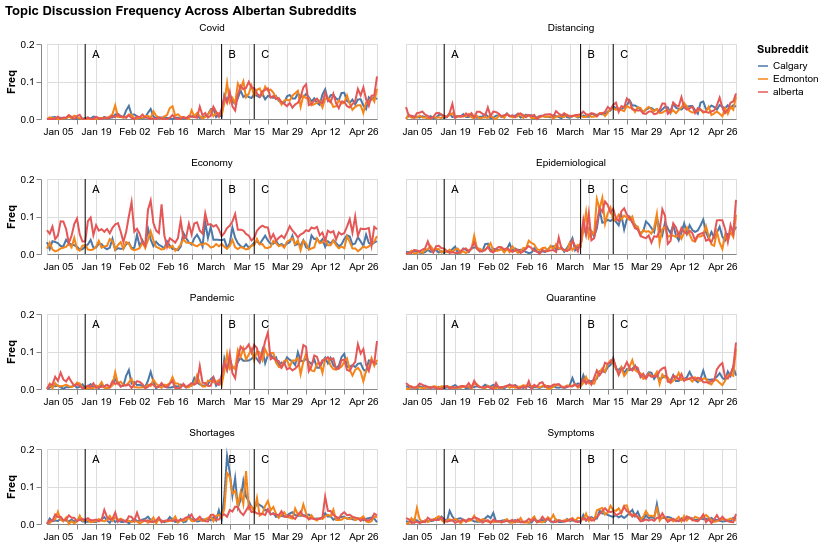

In [14]:
# Build Altair plot

plt = (
    alt.Chart(title="Chart title")
    .mark_line()
    .encode(
        x=alt.X("date", axis=alt.Axis(title=None)),
        y=alt.Y("score:Q", axis=alt.Axis(title="Freq")),
        color=alt.Color(
            "subreddit:O",
            legend=alt.Legend(title="Subreddit"),
            scale=alt.Scale(scheme="tableau10"),
        ),
    )
)

tlc = alt.Chart(timeline).mark_rule().encode(x="date")
labels = tlc.mark_text(align="left", baseline="top", dx=7).encode(
    text="label", y=alt.value(5)
)

plot = (
    (plt + tlc + labels)
    .properties(width=330, height=75)
    .facet(
        alt.Facet("cat:N", title=None),
        data=agg,
        title="Topic Discussion Frequency Across Albertan Subreddits",
        columns=2,
    )
    .resolve_scale(x="independent")
)

plot

| Label | Date      | Event                                   |
|:-----:|:---------:|:----------------------------------------|
| A     |2020-01-15 | Canada's first case                     |
| B     |2020-03-05 | Alberta's first case                    |
| C     |2020-03-17 | Canada Declares Public Health Emergency |

## Conclusions

By visualizing how topic discussion has changed over time we can start to understand how Albertans have reacted to the COVID-19 pandemic. Here are some observations:

- Discussion of the pandemic was rare until after Alberta's first case on March 5th.
- Shortages and hoarding were a major concern for about 10 days. After suppliers dealt with shortages, discussion decreased significantly.
- Ideas about social distancing did not enter the public discourse until two weeks after discussion of COVID-19 peaked.
- Discussion frequency in the `/r/calgary` and `/r/edmonton` subreddits was similar, despite differing COVID-19 case rates between the cities.
- The economy has continued to be a constant topic of disucssion in Albertan subreddits throughout the pandemic. Economic discussion frequency is higher in `/r/alberta` than in `/r/calgary` and `/r/edmonton`.

Reddit comments proved to be a useful source of data for measuring the magnitude of local conversation on topics related to the COVID-19 pandemic. A text classification model trained with social media data to understand local issues could be a helpful tool for government bodies and non-profits. For example, municipal governments could use a trained model to automatically classify 311 complaints with locally relevant keywords.

## Future Work

- Integrate more Canadian cities into the analysis
- Statistical discovery of topics via [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
- Interactive visualization of word vectors with the [tensorboard embedding projector](http://projector.tensorflow.org/)
- Explore using a pre-trained model as a foundation before training with local subreddit comment data
